Using device: cuda
Mounted at /content/drive
Detected 23 classes: ['Abudefduf vaigiensis', 'Acanthurus nigrofuscus', 'Amphipirian clarkii', 'Balistapus undulatus', 'Canthigaster valentini', 'Chaetodan lunulatus', 'Chaetodan trifascialis', 'Chromis chrysura', 'Dascyllus reticulatus', 'Hemigymnus fasciatus', 'Hemigymnus melopterus', 'Lutjanus fulvus', 'Myripristis kuntee', 'Neoglyphidodon nigoris', 'Neoniphon sammara', 'Pempheris vanicolensis', 'Plectroglyphido don dickii', 'Pomacentrus moluccensis', 'Scaridae', 'Scolopsis bilineata', 'Siganus fuscescens', 'Zebrasama scopas', 'Zonclus cornutus']


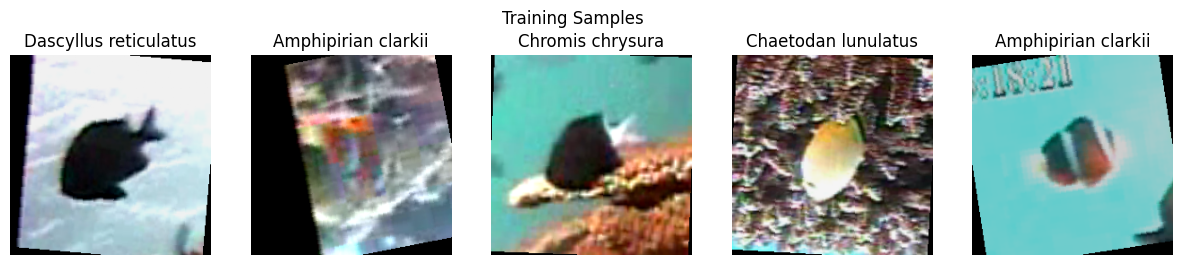

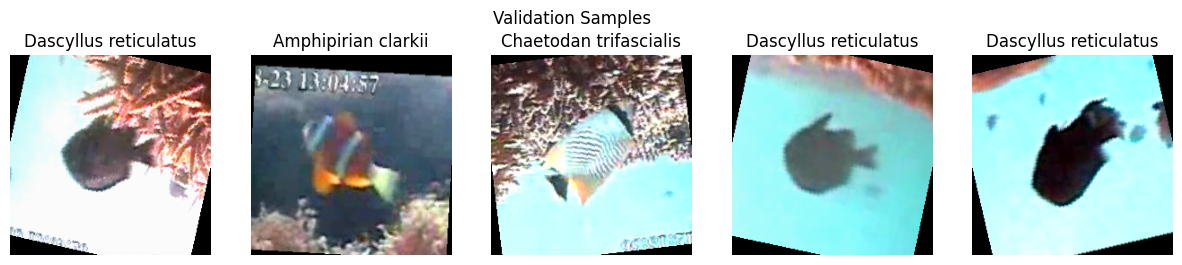

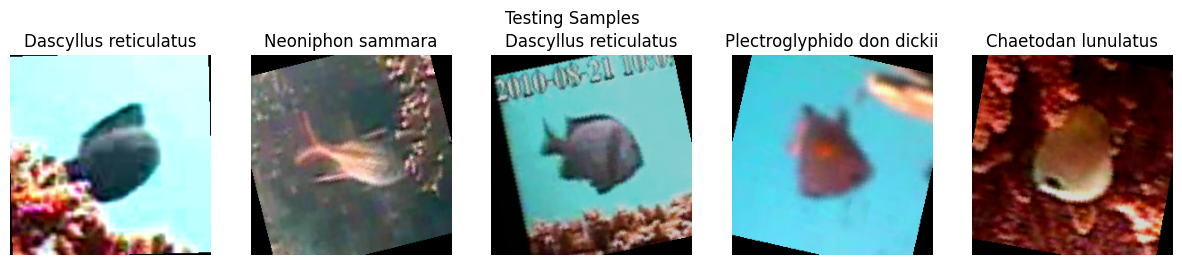

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s]


Epoch 1/6 | Train Loss: 0.3356 | Val Loss: 0.1378 | Val Acc: 0.9619 | Val F1: 0.9554
Epoch 2/6 | Train Loss: 0.0916 | Val Loss: 0.0744 | Val Acc: 0.9801 | Val F1: 0.9786
Epoch 3/6 | Train Loss: 0.0505 | Val Loss: 0.0524 | Val Acc: 0.9840 | Val F1: 0.9835
Epoch 4/6 | Train Loss: 0.0284 | Val Loss: 0.0287 | Val Acc: 0.9928 | Val F1: 0.9929
Epoch 5/6 | Train Loss: 0.0144 | Val Loss: 0.0205 | Val Acc: 0.9950 | Val F1: 0.9950
Epoch 6/6 | Train Loss: 0.0098 | Val Loss: 0.0170 | Val Acc: 0.9957 | Val F1: 0.9957
Training complete!

Test Results
Accuracy : 0.995067592254293
Precision: 0.9951641371309943
Recall   : 0.995067592254293
F1 Score : 0.9950422257434889
Inference Time (s): 64.90033054351807

Classification Report:
                            precision    recall  f1-score   support

      Abudefduf vaigiensis       1.00      1.00      1.00        20
    Acanthurus nigrofuscus       0.86      0.91      0.89        35
       Amphipirian clarkii       1.00      1.00      1.00       812
    

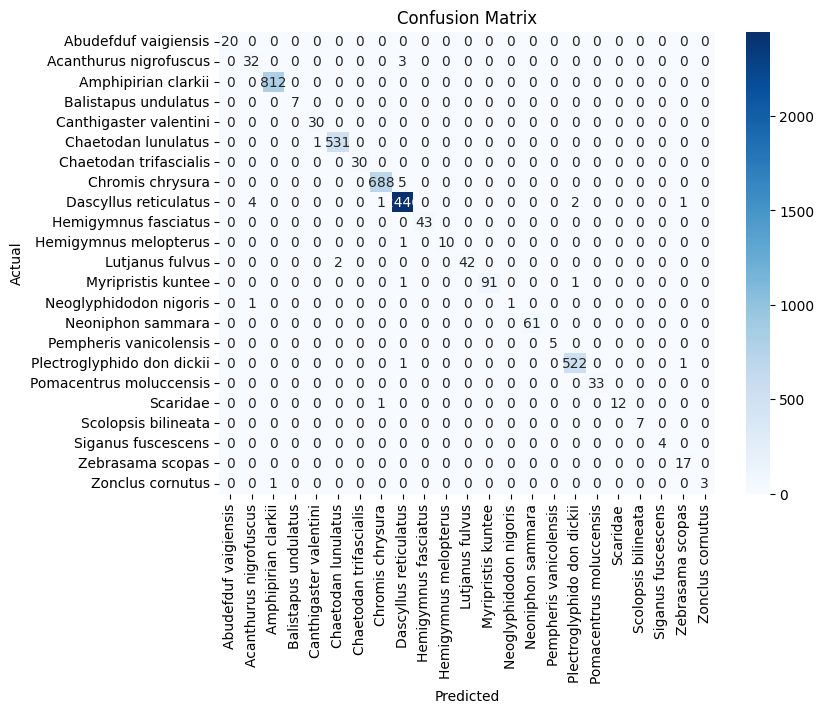

Model saved successfully


In [1]:
# ================================
# INSTALL DEPENDENCIES
# ================================
!pip install -q transformers timm seaborn torchinfo


# ================================
# IMPORTS
# ================================
import os
import zipfile
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
from transformers import SwinModel, SwinConfig
from google.colab import drive
from torchinfo import summary


# ================================
# DEVICE
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ================================
# MOUNT DRIVE & EXTRACT DATA
# ================================
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Fish2Dataset.zip"
extract_path = "/content/Fish2Dataset"

if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)


# ================================
# DATA TRANSFORMS
# ================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])


# ================================
# LOAD DATASET
# ================================
dataset = datasets.ImageFolder(root=extract_path, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print(f"Detected {num_classes} classes:", class_names)


# ================================
# DATA SPLIT (50 / 30 / 20)
# ================================
total_size = len(dataset)
train_size = int(0.5 * total_size)
val_size = int(0.3 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


# ================================
# SHOW SAMPLE IMAGES
# ================================
def show_samples(dataset, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0) * 0.5 + 0.5
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_dataset, "Training Samples")
show_samples(val_dataset, "Validation Samples")
show_samples(test_dataset, "Testing Samples")


# ================================
# DATALOADERS (UPDATED BATCH SIZE)
# ================================
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# ================================
# HYBRID MODEL
# ================================
class HybridResNetSwin(nn.Module):
    def __init__(self, dropout_rate, num_classes):
        super().__init__()

        self.resnet = models.resnet50(
            weights=models.ResNet50_Weights.DEFAULT
        )
        self.resnet.fc = nn.Identity()

        swin_config = SwinConfig()
        self.swin = SwinModel(swin_config)
        self.swin.pooler = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        res_feat = self.resnet(x)
        swin_feat = self.swin(pixel_values=x).last_hidden_state.mean(dim=1)
        fused = torch.cat((res_feat, swin_feat), dim=1)
        return self.classifier(fused)


# ================================
# TRAIN FUNCTION
# ================================
def train(model, train_loader, val_loader,
          criterion, optimizer, scheduler,
          num_epochs, patience):

    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        preds, labels = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item() * x.size(0)
                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                labels.extend(y.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(labels, preds)
        val_f1 = f1_score(labels, preds, average='weighted')

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"Val F1: {val_f1:.4f}"
        )

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_weights)
    print("Training complete!")


# ================================
# UPDATED BEST HYPERPARAMETERS
# ================================
lr = 3.53e-04
weight_decay = 9.96e-06
dropout_rate = 0.2897
num_epochs = 6
patience = 4


# ================================
# MODEL SETUP
# ================================
model = HybridResNetSwin(dropout_rate, num_classes).to(device)

optimizer = optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs
)

criterion = nn.CrossEntropyLoss()


# ================================
# MODEL SUMMARY
# ================================
summary(model, input_size=(1, 3, 224, 224))


# ================================
# TRAIN
# ================================
train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    patience=patience
)


# ================================
# EVALUATION
# ================================
def evaluate(model, test_loader):
    model.eval()
    preds, labels = [], []

    start = time.time()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            labels.extend(y.cpu().numpy())
    end = time.time()

    print("\nTest Results")
    print("Accuracy :", accuracy_score(labels, preds))
    print("Precision:", precision_score(labels, preds, average='weighted'))
    print("Recall   :", recall_score(labels, preds, average='weighted'))
    print("F1 Score :", f1_score(labels, preds, average='weighted'))
    print("Inference Time (s):", end - start)

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names))

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=class_names,
        yticklabels=class_names,
        cmap='Blues'
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


evaluate(model, test_loader)


# ================================
# SAVE MODEL
# ================================
torch.save(model.state_dict(), "hybrid_model_9species.pth")
print("Model saved successfully")
